# Setup

## imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

import platform
import time
import pathlib
import os

## loadataset_stringified

In [3]:
def load_dataset(silent=False):
    # List of dataset files we want to merge
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []
    
    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'./datasets/recipes_raw/{dataset_file_name}'
        
        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list
            
            # This code block outputs a summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  ingredients: ', json_data_list[0]['ingredients'])
                print('\n\n')

    return dataset  

<code>dataset_raw</code> contains all data, unadulterated

In [4]:
dataset_raw = load_dataset(silent=True)

## preprocess data

Checks if the entry contains a non-empty <code>ingredients</code> section

In [5]:
def validate_required_fields(recipe):
    required_keys = ['ingredients']
    
    # If recipe empty
    if not recipe:
        return False
    
    for required_key in required_keys:
        # If there is no required_key entry in recipe
        if not recipe[required_key]:
            return False
        
        # If the required_key entry is an empty list
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
        
    return True

<code>dataset_validated</code> only possesses recipe entries with a non-empty ingredients list

In [6]:
dataset_validated = [recipe for recipe in dataset_raw if validate_required_fields(recipe)]

<code>skim_and_string</code> returns the <code>ingredients</code> entry from a recipe, removes unwanted words and characters, and returns it as a string

WARNING: this might remove parts of words that shouldn't be removed (e.g. drumstick --> drum)

Improve this in the future

Add extra logic to replace whitespace strings with just a single space

In [7]:
def skim_and_string(recipe):
    word_blacklist = [
        'ADVERTISEMENT',
        'cups',
        'cup',
        'tablespoons',
        'tablespoon',
        'teaspoons',
        'teaspoon',
        'ounces',
        'ounce',
        'pounds',
        'pound',
        'packets',
        'packet',
        'pints ',
        'pint ',
        'quarts ',
        'quart ',
        'sprigs',
        'sprig',
        'sticks',
        'stick',
        'cans ',
        'can ',
        'inch ',
        'optional',
        'packages',
        'package',
        'plus ',
        '0','1','2','3','4','5','6','7','8','9',
        '/',
        '-',
        ' to ',
        '(',
        ')',
        '.',
        "'",
        '®',
        ':',
        '™',
        ';',
        '&',
        '%',
        '*',
        '"',
        '–',
        '°',
        'î',
        '!',
        '½',
        '?',
        '¿',
        '=',
        'ó',
        '¼',
        '>',
        '#',
        '<',
        '’',
        '—',
        ']',
        '[',
        '¾',
        '+',
        '}',
        '_',
        '⁄',
        '{',
        '\xad',
        '|',
        '$',
        '‑',
        '`',
        '‚',
        '\\',
        '•',
        '́',
        '×',
        'õ',
        '@',
        '�',
        'ﬁ',
        '‧',
        '‟',
        '‐',
        '©',
        '§',
        'ﬂ',
        '⅞',
        '⅛',
        '″',
        '‱',
        '”',
        '¤',
        '\x96',
        '~'
    ]
    
    ingred_lists = recipe['ingredients']
    
    out = ''
    for ingred_list in ingred_lists:
        for bad_word in word_blacklist:
            ingred_list = ingred_list.replace(bad_word, '')
            
        while ingred_list and ingred_list[0] == ' ':
            ingred_list = ingred_list[1::]
            
        while ingred_list and (ingred_list[-1] == '\n' or ingred_list[-1] == ' '):
            ingred_list = ingred_list[:-1]
        
        if ingred_list:  # if non-empty
            out += f'{ingred_list}\n'
            
    return out

<code>dataset_stringified</code> is an array of cleaned up ingredients lists (strings)

In [8]:
dataset_stringified = [skim_and_string(recipe) for recipe in dataset_validated]

In [9]:
n = -52727
print(dataset_validated[n]['ingredients'])
print()
print(dataset_stringified[n])

['5 cups all-purpose flour, plus extra for board', '2 teaspoons baking powder', '1 teaspoon salt', '4 teaspoons dried thyme', '4 teaspoons dried sage', '4 sticks cold unsalted butter, cut into 1 tablespoon pieces', '12 to 16 tablespoons cold water', '3 tablespoons butter', '1 sweet onion, diced', '1 medium shallot, diced', '5 celery stalks, diced', '1/3 cup all-purpose flour', '4 cups hot chicken stock', '1 rotisserie chicken, meat removed and chopped', '2 cups frozen diced carrots and peas', '2 teaspoons dried sage', 'Salt and freshly ground black pepper', '1 egg, whisked, for egg wash', 'Special equipment: 4 (5-inch) aluminum pot pie pans', 'To prepare the crust:']

allpurpose flour, extra for board
baking powder
salt
dried thyme
dried sage
cold unsalted butter, cut into   pieces
cold water
butter
sweet onion, diced
medium shallot, diced
celery stalks, diced
allpurpose flour
hot chicken stock
rotisserie chicken, meat removed and chopped
frozen diced carrots and peas
dried sage
Salt a

figuring out good choice of <code>MAX_INGREDIENT_LIST_LENGTH</code>

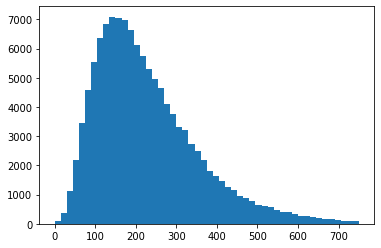

In [10]:
ingredient_list_lengths = []
for ingred_test in dataset_stringified:
    ingredient_list_lengths.append(len(ingred_test))
    
plt.hist(ingredient_list_lengths, bins = 50, range = (0,750))
plt.show()

In [11]:
MAX_INGREDIENT_LIST_LENGTH = 300

<code>dataset_truncated</code> is the subarray of ingredients strings that are shorter than <code>MAX_INGREDIENT_LIST_LENGTH</code>

In [12]:
# This can be taken care with tf layers automatically, but will figure that out later

def filter_ingredients_list_by_length(ingred_list):
    return len(ingred_list) < MAX_INGREDIENT_LIST_LENGTH

dataset_truncated = [ingred_list for ingred_list in dataset_stringified
                     if filter_ingredients_list_by_length(ingred_list)]

In [13]:
STOP_CHAR = '␣'

def pad_ingredients_list(ingred_list, pad_char):
    if len(ingred_list) < MAX_INGREDIENT_LIST_LENGTH + 1:
        ingred_list += (MAX_INGREDIENT_LIST_LENGTH + 1 - len(ingred_list))*STOP_CHAR
    
    return ingred_list

<code>dataset_padded</code> contains the same data as <code>dataset_truncated</code> but with each entry padded to length <code>MAX_INGREDIENT_LIST_LENGTH</code> with <code>STOP_CHAR</code>'s

In [14]:
dataset_padded = [pad_ingredients_list(elem, STOP_CHAR) for elem in dataset_truncated]

## tokenize, generate (data, label) pairs, and batch

Create vocab list for tokenizing. Currently we are tokenizing at the character level.

might want to split based on '\n' so that dictionary consists of all possible ingredients (hopefully unique-ish). even better would be to use a dictionary of ingredients. might also want to 'generate' new data by shuffling the order of ingredients within recipes, since the order doesn't seem like a useful thing to remember

In [15]:
vocab = [entry for sublist in dataset_padded for entry in sublist]
vocab.append(STOP_CHAR)
vocab = sorted(set(vocab))

In [16]:
# gets array of token IDs from a character array
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab),
    mask_token=None,
)

# gets character array from array of token IDs
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=list(vocab),
    mask_token=None,
    invert=True
)

# can pass output of chars_from_ids into here to get nicely formatted string
def str_from_char_array(char_array):
    return tf.strings.join(char_array).numpy().decode('utf-8')

# token ID of STOP_CHAR
STOP_CHAR_ID = ids_from_chars(STOP_CHAR).numpy()

<code>all_ids</code> is Tensor of tokenized entries from <code>dataset_padded</code>

In [17]:
all_ids = ids_from_chars(tf.strings.unicode_split(dataset_padded, 'UTF-8')).to_tensor()
# all_ids_numpy = all_ids.numpy()

# uses depricated function
# tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     char_level=True,
#     filters='',
#     split=''
# )

# tokenizer.fit_on_texts([STOP_CHAR])
# tokenizer.fit_on_texts(dataset_truncated)

# look up with TextVectorization is more useful than StringLookup
# vectorize_layer = tf.keras.layers.TextVectorization(
#     split='character',
#     standardize='lower'
# )

# vectorize_layer.adapt(dataset_truncated)

# temp_model = tf.keras.models.Sequential()
# temp_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# temp_model.add(vectorize_layer)

# temp_model.predict([['-blskd'], ['pastaaaa']])

<code>dataset_tokenized</code> is similar to <code>all_ids</code> but in proper datatype, or something

In [18]:
dataset_tokenized = tf.data.Dataset.from_tensor_slices(all_ids)

In [136]:
# old ateempt at padding using tf APIs
# below code doesn't quite work (works on each element (.take(1)) of dataset_ids)

# dataset_ids_padded = tf.pad(
#     dataset_ids,
#     tf.constant([[0,max(200,0)]]),
#     'CONSTANT',
#     constant_values=STOP_CHAR_ID
# )

<code>split_input_target</code> takes in a string of length <code>n+1</code> and outputs a tuple of length-<code>n</code> arrays used for training next-character prediction

In [19]:
def split_input_target(sequence):
    return sequence[:-1], sequence[1:]

<code>dataset</code> is array of tuples created from <code>dataset_tokenized</code> prepared for training the next-character prediction model

In [20]:
dataset = dataset_tokenized.map(split_input_target)

<code>dataset_train</code> is an object that shuffles the order of <code>dataset</code> and returns a batch of training examples of size <code>BATCH_SIZE</code>. Calling <code>.repeat()</code> makes it so that this object can be called indefinetly (i.e. doesn't 'pop off' elements).

In [21]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000  # used so that we don't have to shuffle entire dataset at once

dataset_train = dataset\
    .shuffle(SHUFFLE_BUFFER_SIZE)\
    .batch(BATCH_SIZE, drop_remainder=True)\
    .repeat()

# build model

## construct model

Builds a model consisting of an embedding layer, followed by a LSTM layer, followed by a dense output layer

figure out how <code>embedding_dim</code> should compare to <code>vocab_size</code>

In [22]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    
    # embedding layer is for learning dense vector representations of int-encoded input characters
    model.add(tf.keras.layers.Embedding(  # input is tensor with shape (batch_size, input_length)
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]  # can't find this in the API documentation...
    ))
    
    # essentially the RNN layer, I think
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    
    # one-vs-many output layer
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
    vocab_size=len(vocab)+1,  # +1 for the reserved index 0
    embedding_dim=128,  # unsure if this should be larger than vocab_size or less than it...
    rnn_units=1024,
    batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 128)           9856      
                                                                 
 lstm (LSTM)                 (64, None, 1024)          4722688   
                                                                 
 dense (Dense)               (64, None, 77)            78925     
                                                                 
Total params: 4,811,469
Trainable params: 4,811,469
Non-trainable params: 0
_________________________________________________________________


Define <code>loss</code> function using <code>sparse_categorical_crossentropy</code>

In [23]:
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True  # states that y_pred is a logits tensor instead of a probability distribution
    )
    
    return entropy

compile the model

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
    loss=loss
)

<code>early_stopping_callback</code> will stop training if model isn't improving after stated number of epochs

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,  # number of epochs
    monitor='loss',  # quantity to monitor
    restore_best_weights=True,  # use weights from before improvement plateaued
    verbose=1  # be verbose
)

In [26]:
# Create a checkpoints directory
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

## train model

In [27]:
EPOCHS = 10
INITIAL_EPOCH = 0
STEPS_PER_EPOCH = 15  # i.e. number of batched per epoch

In [150]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'next_ingred_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 1/10
15/15 [==============================] - 85s 6s/step - loss: 3.6695
Epoch 2/10
15/15 [==============================] - 85s 6s/step - loss: 1.7265
Epoch 3/10
15/15 [==============================] - 86s 6s/step - loss: 1.4381
Epoch 4/10
15/15 [==============================] - 87s 6s/step - loss: 1.2644
Epoch 5/10
15/15 [==============================] - 88s 6s/step - loss: 1.0673
Epoch 6/10
15/15 [==============================] - 89s 6s/step - loss: 0.9014
Epoch 7/10
15/15 [==============================] - 109s 7s/step - loss: 0.7683
Epoch 8/10
15/15 [==============================] - 110s 7s/step - loss: 0.6417
Epoch 9/10
15/15 [==============================] - 110s 7s/step - loss: 0.5341
Epoch 10/10
15/15 [==============================] - 111s 7s/step - loss: 0.4932


## evaluate model

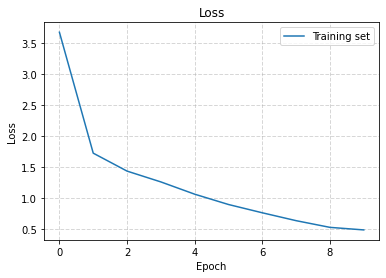

In [176]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

# make predictions

## load/create generative model and function

Since we only want to feed in a single ingredient list that we want it to suggest additions to, we need to rebuild the model with a batchsize of 1, otherwise it would require we feed it BATCH_SIZE lists.

In [28]:
simplified_batch_size = 1

model_simplified = build_model(
    len(vocab)+1,
    embedding_dim=128,
    rnn_units=1024,
    batch_size=simplified_batch_size)

# load learned weights from saved training model
model_simplified.load_weights('./next_ingred_rnn_raw.h5')

# ---------- OR ----------
# load learned weights from last checkpoint
# model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_simplified.build(tf.TensorShape([simplified_batch_size, None]))  # can't find .build() method in the API docs...

model_simplified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 128)            9856      
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           4722688   
                                                                 
 dense_1 (Dense)             (1, None, 77)             78925     
                                                                 
Total params: 4,811,469
Trainable params: 4,811,469
Non-trainable params: 0
_________________________________________________________________


Note on the <code>tf.random.categorical()</code> line: current understanding is that the output of dense layer should be interpereted as (possibly unnormalized) log-probabilities of what the next character should be. Instead of simply returning the character corresponding to the argmax, we'd like to sample from this probability distribution so that our model doesn't always return the same thing each time (i.e. isn't determininistic). I think we control 'how deterministic' our model will be via the <code>temperature</code> parameter.

Pretty sure <code>tf.random.categorical</code> is the same as sampling from a discrete distribution, but with the input as log-probabilities instead of the PMF.

Question: do when calling the model a second time, do we only need to supply the next character? or the whole string with that character appended?

In [29]:
def generate_text(model, start_string, num_generate=40, temperature=1.0):
    # tokenize start_string
    input_indices = ids_from_chars(tf.strings.unicode_split(start_string, 'UTF-8'))

    generated_text = []

    # batch size = 1
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(tf.expand_dims(input_indices, 0))  # need to expand so this is a batch of size 1
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # use categorical distribution to predict the next character
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # pass predicted character as the next input to the model along with previous hidden state
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = str_from_char_array(chars_from_ids(input_indices[0]))

        generated_text.append(next_character)

    return(start_string + ''.join(generated_text))

## output

In [48]:
print(generate_text(model_simplified, 'eggs\nflour\n', num_generate=100, temperature=.7))

eggs
flour
baking soda
salt
eggs
vanilla extract
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣
